# Introduction

In this Jupyter notebook we'll be attempting to model the performance of the straight-bladed propellers from Evans and Liner (1951).

This will give an introduction to blade form curves, and we will start to build our blade element model - with which we shall couple a momentum model, and then _hopefully_ be able to make prediction of $C_T$ and $C_P$ vs $J$...

Evans, A., Liner, G. (1951). A Wind-Tunnel Investigation of the Aerodynamic Characteristics of a Full-Scale Sweptback Propeller and Two Related Straight Propellers

## Blade Form Curves

To describe the geometry of complex three-dimensional blades, the only information actually required for unswept blades is actually the $C_{ld}$, chord ($c$), $\frac{t}{c}$, and twist $\beta$. These are defined in *blade form curves*. See the extract from Evans and Liner (1951), below:


<img src="BladeFormCurves.png" width=400 />

It will be useful for us to be able to define a Python module that enables us to supply:

- Propeller number (I, II, or III)
- A list, or np array of $x$ locations

and have returned the quantities we're after as arrays or lists of the same size as the $x$ that was given to us

Whilst we're not interested in the swept blade _yet_ , we might be at a future date* - so we can include that functionality later.

*_This is the royal 'we' - I am very interested, but it's just a little too much to tackle in this group right now. Baby steps_



There is a module that you can import that does this work for us - it's called LinerProp - we can see that the interpolation produces some areas of the curves that are not continuous. This doesn't matter _too_ much for our purposes, but it would be nice not to have them.

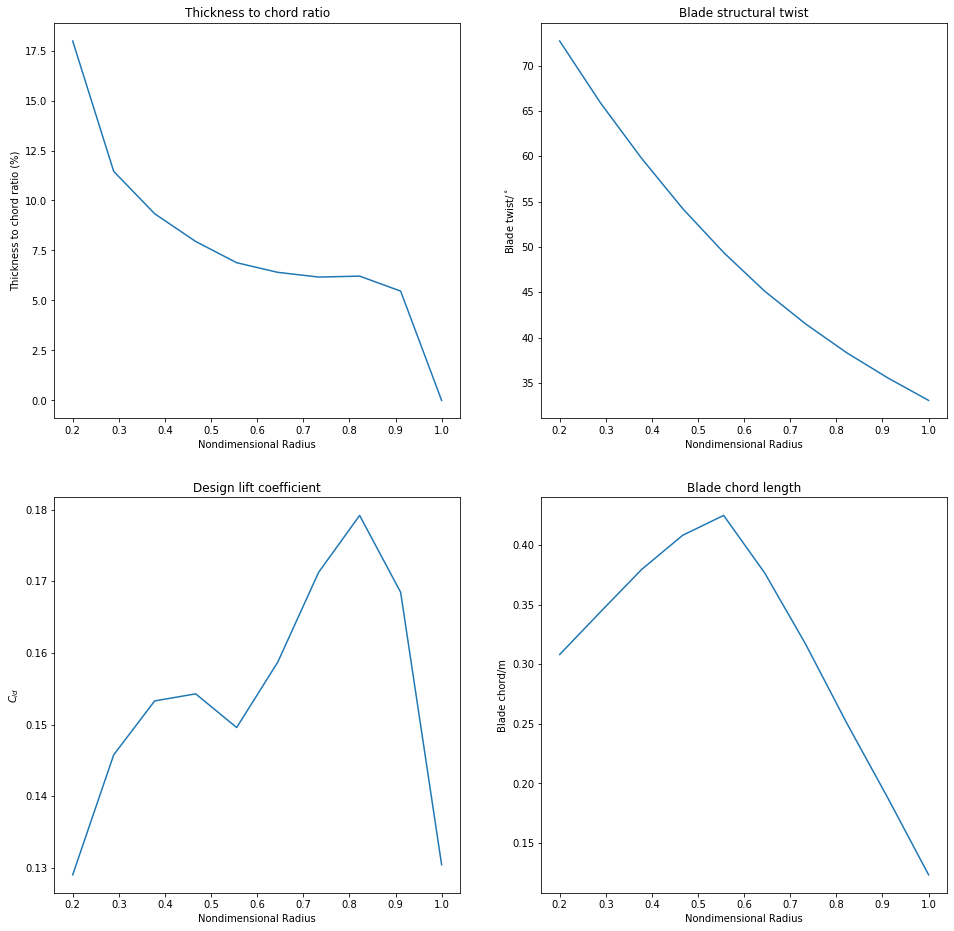

In [1]:
# Make a linearly spaced vector defining nr blade element stations
import numpy as np
nr = 10
x = np.linspace(.2, 1, nr)

# Get the parameters for Blade II at this station
import LinerProp
params = LinerProp.FormCurves(2, x)

import matplotlib.pyplot as plt 

plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(x, params['t_c']*100)
plt.xlabel('Nondimensional Radius')
plt.ylabel('Thickness to chord ratio (%)')
plt.title('Thickness to chord ratio')

plt.subplot(222)
plt.plot(x, params['beta'])
plt.xlabel('Nondimensional Radius')
plt.ylabel('Blade twist/$^\circ$')
plt.title('Blade structural twist')

plt.subplot(223)
plt.plot(x, params['Cld'])
plt.xlabel('Nondimensional Radius')
plt.ylabel('$C_{ld}$')
plt.title('Design lift coefficient')

plt.subplot(224)
plt.plot(x, params['c'])
plt.xlabel('Nondimensional Radius')
plt.ylabel('Blade chord/m')
plt.title('Blade chord length')

# Make these into their own variables
t_c = params['t_c']
twist = params['beta']
Cld = params['Cld']
c = params['c']


## Performance data

We will look at the data available for Propeller II - this is given in Table I in Liner and Evans (1951), and shows that this propeller was tested at blade angles of 20$^\circ$ to 60$^\circ$, in 5$^\circ$ increments.

What do we mean by blade angle?

The twist distribution, $\beta(x)$ is given by the methods above - which determines the relationships between different segments in terms of rotation around the Pitch Change Axis.

On a variable pitch propeller, the whole blade can be twisted about the PCA as a single unit. This is performed to achieve better performance over a range of advance ratios _without_ having to change the propeller speed.

*Think: why do we want to keep the rotational speed constant?*

We need a single number to define the setting angle, and the parameter often used is $\beta_{0.7}$ - which defines the _total_ twist angle at the 70% radius station. This might be slightly confusing in terms of nomnenclature but is historically accurate. I've chosen to call the setting angle "A7" below.

You will see from the diagrams above that the twist at the 70% radius, $\beta(0.7)$ is about 42$^\circ$. It is not equal to any of the blade setting angles given in Table I, hence the blade has been rotated in all cases. We can look at the difference between $\beta_{0.7}$ and $\beta(0.7)$ as an offset that must be added to all positions - defined as $A_0$.

This is trivial to implement, but I've included some coding advice on how to achieve this in the passage below. Compare the two methods of iterating on each item in A0:

In [2]:
from scipy.interpolate import interp1d
# define the blade setting angle as a numpy array
# A7s = np.arange(20, 65, 5)
A7s = np.array([20, 30, 35, 40, 45, 50, 55])

# determine the exact twist at the 70% radius station, beta(0.7)
binterp = interp1d(x, twist, kind='cubic')
b7 = binterp(0.7)
print("The built in twist at the 70% radius station is {b7:1.2f} degrees".format(b7=b7))

# now determine the offset to be added to each station
A0s = [A7 - b7 for A7 in A7s] # At first I thought this had to be a list comprehension because we're subtracting a scalar from a vector
A0s = A7s - b7 # But numpy is pretty smart and when you subtract a scalar from a vector, it figures it out

# This next bit just shows how to operate on numpy arrays or lists. We need to be able to access the different values
# of A0s and A7s in order to create our beta vector. So one means of doing this is to create a for loop that iterates on
# an index - see below
for i in range(len(A0s)):
    print("For blade setting {A7:1.0f}, the offset added is {A0:1.2f}".format(A7=A7s[i], A0=A0s[i]))
    
print(" ")
# The above syntax is easy to set up, but I find it slightly confusing sometimes as the object that is iterated
# isn't either of A0s or A7s. It would be more useful if the "iterable" was BOTH A0 and A7, then we wouldn't need to
# bother with the square bracket indexing

# This can be achieved by combining A0s and A7s into a 2D array
A0s = np.array(A0s) # These don't need to be numpy arrays, they can stay as lists - but if they're arrays it helps with determinign the shape of each
A7s = np.array(A7s)

print("The size of A0s and A7s is {} and {}, respectively".format(A0s.shape, A7s.shape))

# We can combine these in an n x 2 array using "zip" - look at what this does
newarray = zip(A0s, A7s)

# But this doesn't yet look like it's useful
print("We have created - ", newarray)

# We could make this into a list for our own viewing
print("We can view this - ", list(newarray))

# But, actually, the most useful part is that we can do the same for loop that we tried before
# on this zip object without converting into a list, and it allows us to iterate directly on BOTH A0 and A7:
for A0, A7 in zip(A0s, A7s):
    print("For blade setting {A7:1.0f}, the offset added is {A0:1.2f}".format(A7=A7, A0=A0))

The built in twist at the 70% radius station is 42.80 degrees
For blade setting 20, the offset added is -22.80
For blade setting 30, the offset added is -12.80
For blade setting 35, the offset added is -7.80
For blade setting 40, the offset added is -2.80
For blade setting 45, the offset added is 2.20
For blade setting 50, the offset added is 7.20
For blade setting 55, the offset added is 12.20
 
The size of A0s and A7s is (7,) and (7,), respectively
We have created -  <zip object at 0x7fd8204cd5f0>
We can view this -  [(-22.795536381775108, 20), (-12.795536381775108, 30), (-7.795536381775108, 35), (-2.7955363817751078, 40), (2.2044636182248922, 45), (7.204463618224892, 50), (12.204463618224892, 55)]
For blade setting 20, the offset added is -22.80
For blade setting 30, the offset added is -12.80
For blade setting 35, the offset added is -7.80
For blade setting 40, the offset added is -2.80
For blade setting 45, the offset added is 2.20
For blade setting 50, the offset added is 7.20
Fo

Now we'll actually use this method to create a new set of beta values for our propeller that describe the total twist for any setting angle given. We will store this as a dictionary.

The plot produced below isn't necessary for anything, really - but I like to check that the operations I've performed are actually doing what I think they're doing - hence why I plot things out as I go along. It helps with pinpointing errors when/if you make them.

[72.72360198 65.86559846 59.7676263  54.23699734 49.38865998 45.12192855
 41.50255362 38.33113725 35.5607553  33.06441174]


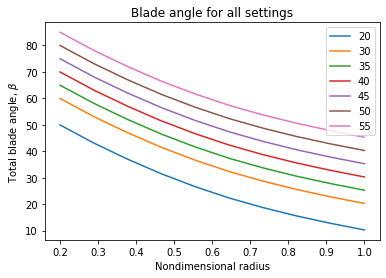

In [3]:
beta = {} # make the beta object into an empty 'dictionary' which allows us to store variable via a lookup 'key'

plt.figure()

# Our lookup key will be the setting angle
for A0, A7 in zip(A0s, A7s):
    beta[A7] = twist + A0
    plt.plot(x, beta[A7], label=A7)
    
plt.legend()
plt.xlabel('Nondimensional radius')
plt.ylabel('Total blade angle, $\\beta$')
plt.title('Blade angle for all settings');

print(twist)

## Reproducing the Liner Performance Data

In the updated LinerProp module, there is a function called "PerformanceData". If you supply the .csv file from Enguage, then this extracts the J and CT values - we can plot them here.

In [4]:
%%capture 
#<=== A whole bunch of junk is being printed to screen - rather than figure why, I'm suppressing the output
import LinerProp;
LinerFigure = "Figures/Liner_15_a.csv"

LinerData = LinerProp.PerformanceData(LinerFigure)

Text(0.5, 1.0, 'Figure 15 from Liner and Evans (1951) reproduced')

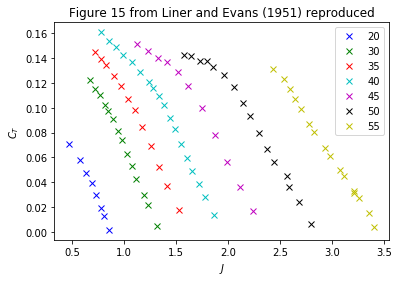

In [5]:
blangs = list(LinerData.keys())

colours = ['b', 'g', 'r', 'c', 'm', 'k', 'y', 'b', 'g']
i = 0
for b in blangs:
    plt.plot(LinerData[b][0, :], LinerData[b][1, :], 'x', color=colours[i], label=b)
    i = i + 1

plt.legend()
plt.xlabel('$J$')
plt.ylabel('$C_T$')
plt.title("Figure 15 from Liner and Evans (1951) reproduced")

### Determination of the conditions we'd like to model from the plot above

In the figure above, there are seven blade angles and each has a different number of data points associated. Each of these data points represents a measurement taken during the experiment performed nearly seventy years ago!

We'd like to make many more predictions using our to-be-constructed model, and then we can overlay our predictions as lines on the data above.

The first step to take is to determine the range of J to perform each calculation at

In [6]:
# blangs is our list of blade angles from the plot above
Js = {}
for b in blangs:
    Jmin = LinerData[b][0, :].min()
    Jmax = LinerData[b][0, :].max() + .3
    Js[b] = np.linspace(Jmin, Jmax, 10)

Thickness ratio in (0.00) outside of table range - setting to t/c = 0.03
[12.80733726 15.41633169 15.13650198 13.46996241 11.35169113  9.10789562
  7.04399013  5.10415117  3.33222365  1.66121251]
[ 8.67034646 11.79964446 12.06156441 10.83774983  9.06714545  7.09731131
  5.25244214  3.49065574  1.86578765  0.31800579]
[ 4.99785832  8.44020654  9.13249986  8.29336759  6.83869099  5.12440703
  3.48729462  1.89631562  0.41366184 -1.0142439 ]
[ 1.74131789  5.33220914  6.35337641  5.84200761  4.6707687   3.19267259
  1.75124002  0.32321368 -1.02252605 -2.33424847]
[-1.14835619  2.46475889  3.72504452  3.48713292  2.5668911   1.30508064
  0.04666971 -1.22675007 -2.44126377 -3.64079531]
[-3.71739254 -0.17625092  1.24573132  1.23063977  0.5296778  -0.53591254
 -1.62433318 -2.75186625 -3.841161   -4.93275228]
[-6.00756909 -2.60665475 -1.08837206 -0.92694861 -1.43908727 -2.32835425
 -3.25999459 -4.25062037 -5.2209539  -6.20907162]
[-8.05570471 -4.84291285 -3.2825709  -2.98627424 -3.33838317 -4.07

[0, 3.8, 0, 0.25]

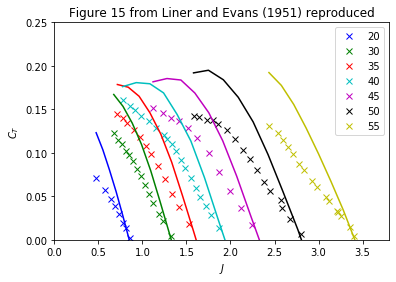

In [11]:
blangs = list(LinerData.keys())

colours = ['b', 'g', 'r', 'c', 'm', 'k', 'y', 'b', 'g']
i = 0
for b in blangs:
    plt.plot(LinerData[b][0, :], LinerData[b][1, :], 'x', color=colours[i], label=b)
    i = i + 1

plt.legend()
plt.xlabel('$J$')
plt.ylabel('$C_T$')
plt.title("Figure 15 from Liner and Evans (1951) reproduced")

# Input the operating conditions
RPM = 1140
n = RPM/60 # Revolutions per second
om = n*2*np.pi
D = 10*.3048 # Prop diameter in m
B = 2 # Number of blades

# Get the interpolants for each blade section
import sys
sys.path.append('../Aerodynamic Databank/N16Databank')
import NACA16databank
Clfunct = []
Cdfunct = []
Clfunctsup = []
Cdfunctsup = []
for cld, tc in zip(Cld, t_c):
    f1, f2, f3, f4 = NACA16databank.MakeInterpolants(cld, tc)
    Clfunct.append(f1)
    Clfunctsup.append(f2)
    Cdfunct.append(f3)
    Cdfunctsup.append(f4)

j = 0
for b in blangs:
    CT = np.array([])
    for J in Js[b]:
        Vn = J*n*D # What is the freestream velocity for the current iteration
        
        # Determine the advance angle all across the disc with no induced velocity
        Vt = om*x*D/2 # Tangential velocity due to rotation
        
        phi = np.arctan2(Vn, Vt)
        
        # This gives us the angle of attack from Alpha = Beta - Phi
        alfa = beta[int(b)] - phi*180/np.pi

        # And the resultant velocity and Mach number
        Vr = np.sqrt(Vn**2 + Vt**2)
        Mr = Vr/340
       
        # Make an interpolant list that has the correct sub or supersonic values in
        ClInt = Clfunct[:]
        CdInt = Cdfunct[:]
        i = 0
        for m in Mr:
            if m > 1:
                ClInt[i] = Clfunctsup[i]
                CdInt[i] = Cdfunctsup[i]
            i = i + 1
        
            
        # Now loop through the radial stations and lookup the Cl and Cd values
        # This is a pretty nifty list comprehension here:
        print(alfa)
        Cl = [f(al, m)[0] for f, al, m in zip(ClInt, alfa, Mr)]
        Cd = [f(al, m)[0] for f, al, m in zip(CdInt, alfa, Mr)]
        
        Cl = np.array(Cl)
        Cd = np.array(Cd)

        
        # Turn this into dimensional values of lift and drag per unit span
        dl = Cl*.5*1.225*Vr**2*c
        dd = Cd*.5*1.225*Vr**2*c
        
        # And now into thrust and tangential force contributions - these are dT/dr and dQ/dr
        dT = dl*np.cos(phi) - dd*np.sin(phi)
        dQ = dl*np.sin(phi) + dd*np.cos(phi)
        
        # Integrate the thrust - which we need to do over
        T = np.trapz(dT, x*D/2)*B

        # Convert to thrust coefficient
        CT = np.append(CT, T/1.225/n**2/D**4)
    
    plt.plot(Js[b], CT, '-', color=colours[j])
    j = j + 1

plt.axis([0, 3.8, 0, .25])

In [8]:
CT

array([-0.03361858, -0.05107359, -0.06435608, -0.0727338 , -0.0707748 ,
       -0.05856738, -0.04112272, -0.02165925, -0.00150673,  0.02073377])